In [1]:
#importing Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import *
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import export_graphviz

/home/zozo/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
#set path
os.chdir("/home/zozo/Documents/edwisor/Project/Cab Fare/")

In [3]:
#check path
os.getcwd()

'/home/zozo/Documents/edwisor/Project/Cab Fare'

In [4]:
#Load Train and Test data
train=pd.read_csv("train_cab.csv")
test=pd.read_csv("test.csv")
train.shape

(16067, 7)

In [5]:
test.shape

(9914, 6)

In [6]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0


In [7]:
#check datatypes of train
train.dtypes

fare_amount           object
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      float64
dtype: object

In [7]:
#convert datatypes
train['fare_amount'].loc[1123]=430
train['fare_amount']=pd.to_numeric(train['fare_amount'])
train['passenger_count']=train['passenger_count'].astype(object)


/home/zozo/.local/lib/python3.7/site-packages/pandas/core/indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


### Missing Value Analysis

In [8]:
#Create dataframe with missing percentage
missing_val = pd.DataFrame(train.isnull().sum())

#Reset index
missing_val = missing_val.reset_index()

#Rename variable
missing_val = missing_val.rename(columns = {'index': 'Variables', 0: 'Missing_percentage'})

#Calculate percentage
missing_val['Missing_percentage'] = (missing_val['Missing_percentage']/len(train))*100

#descending order
missing_val = missing_val.sort_values('Missing_percentage', ascending = False).reset_index(drop = True)

In [48]:
missing_val

,Variables,Missing_percentage
0,passenger_count,0.342317
1,fare_amount,0.149374
2,pickup_datetime,0.000000
3,pickup_longitude,0.000000
4,pickup_latitude,0.000000
5,dropoff_longitude,0.000000
6,dropoff_latitude,0.000000


In [11]:
#As Passnenger_count is a categorical variable we will use mode to impute it

In [11]:
train['passenger_count'].value_counts()

1.00       11259
2.00        2322
5.00        1045
3.00         676
4.00         329
6.00         302
0.00          57
43.00          2
53.00          2
87.00          1
35.00          1
55.00          1
58.00          1
0.12           1
5345.00        1
345.00         1
354.00         1
456.00         1
1.30           1
531.20         1
535.00         1
536.00         1
537.00         1
554.00         1
557.00         1
5334.00        1
236.00         1
Name: passenger_count, dtype: int64

In [9]:
#mode- as 1 has occurred for most no. of times we will replace na with 1 i.e Mode

train['passenger_count'] = train['passenger_count'].fillna(1)


In [13]:
#Now to impute missing value of fare_amount we will use Mean or Median

In [10]:
train['fare_amount'].loc[2000]

17.7

In [16]:
#actual value=17.7
#mean=15.0407
#median=8.5
#As Mean is giving better result we will use mean to replace na in fare_amount variable

In [11]:
#Mean
train['fare_amount'] = train['fare_amount'].fillna(train['fare_amount'].mean())


In [18]:
#Median
#train['fare_amount'] = train['fare_amount'].fillna(train['fare_amount'].median())


In [16]:
missing_val

,Variables,Missing_percentage
0,fare_amount,0.0
1,pickup_datetime,0.0
2,pickup_longitude,0.0
3,pickup_latitude,0.0
4,dropoff_longitude,0.0
5,dropoff_latitude,0.0
6,passenger_count,0.0


### Now we will remove outlier location from train data using test dataset

In [17]:
#Pickup latitude range
print("Range of Pickup Latitude is", (min(train['pickup_latitude']),max(train['pickup_latitude'])))


Range of Pickup Latitude is (-74.006893, 401.083332)


In [18]:
#Dropoff latitude range
print("Range of Dropoff Latitude", (min(train['dropoff_latitude']),max(train['dropoff_latitude'])))


Range of Dropoff Latitude (-74.006377, 41.366138)


In [19]:
# now lets see what are the boundaries in test dataset 

In [20]:
#longitude boundary
print("Longitude Boundary in test")
min(test.pickup_longitude.min(), test.dropoff_longitude.min()),max(test.pickup_longitude.max(), test.dropoff_longitude.max())

Longitude Boundary in test


(-74.263242, -72.986532)

In [21]:
#latitude boundary
print("Latitude Boundary in test")
min(test.pickup_latitude.min(), test.pickup_latitude.min()),max(test.pickup_latitude.max(), test.pickup_latitude.max())

Latitude Boundary in test


(40.573143, 41.709555)

In [12]:
#set boundaries
boundary={'min_longitude':-74.263242,
              'min_latitude':40.573143,
              'max_longitude':-72.986532, 
              'max_latitude':41.709555}

In [13]:
train.loc[~((train.pickup_longitude >= boundary['min_longitude'] ) & (train.pickup_longitude <= boundary['max_longitude']) &
            (train.pickup_latitude >= boundary['min_latitude']) & (train.pickup_latitude <= boundary['max_latitude']) &
            (train.dropoff_longitude >= boundary['min_longitude']) & (train.dropoff_longitude <= boundary['max_longitude']) &
            (train.dropoff_latitude >=boundary['min_latitude']) & (train.dropoff_latitude <= boundary['max_latitude'])),'outlier']=1
train.loc[((train.pickup_longitude >= boundary['min_longitude'] ) & (train.pickup_longitude <= boundary['max_longitude']) &
            (train.pickup_latitude >= boundary['min_latitude']) & (train.pickup_latitude <= boundary['max_latitude']) &
            (train.dropoff_longitude >= boundary['min_longitude']) & (train.dropoff_longitude <= boundary['max_longitude']) &
            (train.dropoff_latitude >=boundary['min_latitude']) & (train.dropoff_latitude <= boundary['max_latitude'])),'outlier']=0

# Let us drop outlier locations
train=train.loc[train['outlier']==0]
train.drop(['outlier'],axis=1,inplace=True)

In [14]:
train.shape

(15713, 7)

### Now let us extract important features from pickup_datetime

In [15]:
#lets create a function to get important features from pickup_datetime variable in train and test datasets
def clean(data):
    data['pickup_datetime']=data.pickup_datetime.str.slice(-23,-3)
    data['pickup_datetime']=pd.to_datetime(data.pickup_datetime)
    data['day'] = data['pickup_datetime'].dt.day
    data['year'] = data['pickup_datetime'].dt.year 
    data['month'] = data['pickup_datetime'].dt.month 
    data['hour'] = data['pickup_datetime'].dt.hour 
    data['weekday'] = data['pickup_datetime'].dt.weekday
    data=data.dropna(subset=['year','month','hour','weekday'])
    return data


In [16]:
train=clean(train)

In [17]:
train.shape

(15712, 12)

In [18]:
test=clean(test)

In [19]:
test.shape

(9914, 11)

### Now let's calculate trip distance from picup and dropoff latitude and longitude

In [20]:
def trip_distance(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c  
    return km

In [21]:
train['trip_distance']=trip_distance(train['pickup_longitude'],train['pickup_latitude'],
                                     train['dropoff_longitude'],train['dropoff_latitude'])

In [22]:
train.shape

(15712, 13)

In [23]:
test['trip_distance']=trip_distance(test['pickup_longitude'],test['pickup_latitude'],
                                     test['dropoff_longitude'],test['dropoff_latitude'])

In [24]:
test.shape

(9914, 12)

In [29]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,year,month,hour,weekday,trip_distance
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1.0,15.0,2009.0,6.0,17.0,0.0,1.030764
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1.0,5.0,2010.0,1.0,16.0,1.0,8.450134
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2.0,18.0,2011.0,8.0,0.0,3.0,1.389525
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1.0,21.0,2012.0,4.0,4.0,5.0,2.799270
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1.0,9.0,2010.0,3.0,7.0,1.0,1.999157


In [36]:
#Now look at the summary of the data
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,year,month,hour,weekday,trip_distance
count,15712.000000,15712.000000,15712.000000,15712.000000,15712.000000,15712.000000,15712.000000,15712.000000,15712.000000,15712.000000,15712.000000,15712.000000
mean,15.096866,-73.974743,40.751361,-73.973763,40.751904,2.624212,15.667324,2011.734916,6.265784,13.505028,3.031886,3.367074
std,434.964707,0.041117,0.031319,0.039085,0.033255,61.392330,8.683481,1.867260,3.448486,6.506674,1.970197,4.106998
min,-3.000000,-74.181602,40.604462,-74.183955,40.574652,0.000000,1.000000,2009.000000,1.000000,0.000000,0.000000,0.000000
25%,6.000000,-73.992386,40.736661,-73.991372,40.736370,1.000000,8.000000,2010.000000,3.000000,9.000000,1.000000,1.257105
50%,8.500000,-73.982053,40.753366,-73.980571,40.754260,1.000000,16.000000,2012.000000,6.000000,14.000000,3.000000,2.169670
75%,12.500000,-73.968117,40.767805,-73.965393,40.768338,2.000000,23.000000,2013.000000,9.000000,19.000000,5.000000,3.893488
max,54343.000000,-73.137393,41.366138,-73.137393,41.366138,5345.000000,31.000000,2015.000000,12.000000,23.000000,6.000000,101.094619


#### 1.look at the summary of fare_amount,passenger_count and trip_distance
#### 2.fare_amount has minimun value as negative value which is not possible so we will drop negative values
#### 3.passenger_count has minimum value 0 which also does not have any significant value for our model so we will drop it
#### 4.trip_distance also has minimum value as 0 which is also of no use


In [40]:
#let's clean fare_amount variable

In [25]:
#Removing all the fares having value zero
train.drop(train[train['fare_amount'] < 1].index, inplace = True)

In [26]:
#Removing all the passenger_counts having value zero or more than six
train=train[train['passenger_count']<=6]
train=train[train['passenger_count']>=1]


In [27]:
#lets check values of passenger_counts
train['passenger_count'].value_counts()

1.0    11051
2.0     2281
5.0     1023
3.0      662
4.0      320
6.0      295
1.3        1
Name: passenger_count, dtype: int64

### there cannot be 1.3 passenger so lets remove it

In [28]:
train=train[train['passenger_count']!=1.3]

In [29]:
##Now remove the trip_distance having value less than 0.2 as most of people will not take a cab for distance below 200 meters
train = train.loc[train['trip_distance'] >=0.2]

In [68]:
train['trip_distance'].value_counts()

1.205594     1
1.982825     1
2.112972     1
10.857929    1
1.047780     1
            ..
11.193472    1
2.303258     1
1.235731     1
3.651410     1
0.705864     1
Name: trip_distance, Length: 15345, dtype: int64

In [43]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,year,month,hour,weekday,trip_distance
count,15345.000000,15345.000000,15345.000000,15345.000000,15345.000000,15345.000000,15345.000000,15345.000000,15345.000000,15345.000000,15345.000000,15345.000000
mean,15.196998,-73.975269,40.751209,-73.974274,40.751758,1.649853,15.661714,2011.742522,6.273900,13.505898,3.036038,3.433484
std,440.128546,0.037531,0.029037,0.035228,0.031143,1.266128,8.686279,1.871450,3.449016,6.507424,1.970803,4.125446
min,1.140000,-74.133710,40.609495,-74.183955,40.574652,1.000000,1.000000,2009.000000,1.000000,0.000000,0.000000,0.200437
25%,6.000000,-73.992410,40.736686,-73.991376,40.736413,1.000000,8.000000,2010.000000,3.000000,9.000000,1.000000,1.299040
50%,8.500000,-73.982094,40.753389,-73.980582,40.754279,1.000000,16.000000,2012.000000,6.000000,14.000000,3.000000,2.210763
75%,12.500000,-73.968260,40.767805,-73.965588,40.768339,2.000000,23.000000,2013.000000,9.000000,19.000000,5.000000,3.956398
max,54343.000000,-73.137393,41.366138,-73.137393,41.366138,6.000000,31.000000,2015.000000,12.000000,23.000000,6.000000,101.094619


###Now if you will carefully look at the summary of data you will find out that max value in fare_amount is 54343
which is way more than the mean value which is 15.19 that means this is an outlier. Same is the case with trip_distance where mean is 3.4 and max value is 101.09 so lets remove outliers from data

###  outliers

In [48]:
#first look at the relation between trip_distance and fare_amount

Text(0.5, 1.0, 'Trip Distance vs Fare Amount')

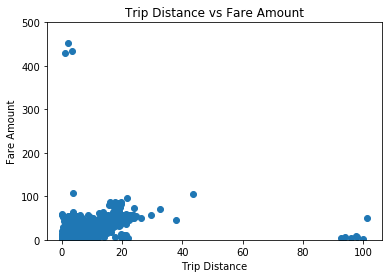

In [36]:
plt.scatter(x=train['trip_distance'],y=train['fare_amount'])
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.ylim(0, 500)
plt.title("Trip Distance vs Fare Amount")

#### As you can see in scatterplot that fare amount is almost fixed for trip over 80 kM and sometimes fares are very high for very short distance which is basically an outlier.

{'whiskers': [<matplotlib.lines.Line2D at 0x7f80f30881d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f80e88d48d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f80eb166da0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f80e88d4f60>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f80e88d4eb8>],
 'means': []}

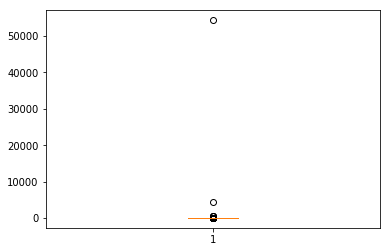

In [37]:
# #Plot boxplot to visualize Outliers
%matplotlib inline  
plt.boxplot(train['fare_amount'])

###### Now after looking the scatter plot of Fare vs Trip_distance and boxplot of Fare amount we will remove all the fares having value more than 150

In [30]:
train=train[train['fare_amount']<150]

###### Now lets draw boxplot for trip_distance for train and test datasets

{'whiskers': [<matplotlib.lines.Line2D at 0x7f91e7e9b470>,
 'caps': [<matplotlib.lines.Line2D at 0x7f91e7e9bb00>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f91e7e9b080>],
 'medians': [<matplotlib.lines.Line2D at 0x7f91e7e9bf28>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f91e7e24518>],
 'means': []}

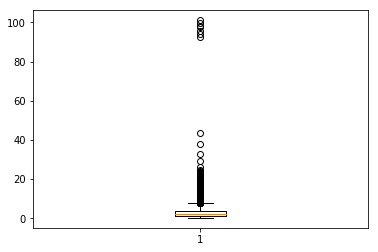

In [47]:
%matplotlib inline  
plt.boxplot(train['trip_distance'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f91e44e0dd8>,
 'caps': [<matplotlib.lines.Line2D at 0x7f91e44ec4a8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f91e44e09e8>],
 'medians': [<matplotlib.lines.Line2D at 0x7f91e44ecb38>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f91e44ece80>],
 'means': []}

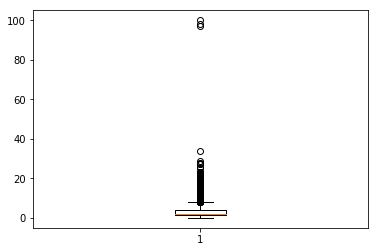

In [48]:
%matplotlib inline  
plt.boxplot(test['trip_distance'])

##### After visualising boxplot for trip_distance of train and test datasets we know that they contain almost same trip distance so we will leave trip distance as it is.

In [31]:
train.shape

(15340, 13)

In [50]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,year,month,hour,weekday,trip_distance
count,15340.000000,15340.000000,15340.000000,15340.000000,15340.000000,15340.000000,15340.000000,15340.000000,15340.000000,15340.000000,15340.000000,15340.000000
mean,11.290413,-73.975264,40.751210,-73.974272,40.751757,1.650000,15.660887,2011.742568,6.274316,13.504759,3.036115,3.433466
std,9.280362,0.037535,0.029040,0.035231,0.031144,1.266288,8.686197,1.871419,3.448840,6.507487,1.970742,4.125994
min,1.140000,-74.133710,40.609495,-74.183955,40.574652,1.000000,1.000000,2009.000000,1.000000,0.000000,0.000000,0.200437
25%,6.000000,-73.992409,40.736687,-73.991376,40.736409,1.000000,8.000000,2010.000000,3.000000,9.000000,1.000000,1.299001
50%,8.500000,-73.982093,40.753391,-73.980589,40.754278,1.000000,16.000000,2012.000000,6.000000,14.000000,3.000000,2.210627
75%,12.500000,-73.968255,40.767805,-73.965591,40.768338,2.000000,23.000000,2013.000000,9.000000,19.000000,5.000000,3.955927
max,108.000000,-73.137393,41.366138,-73.137393,41.366138,6.000000,31.000000,2015.000000,12.000000,23.000000,6.000000,101.094619


In [56]:
#now you can see after removing ouliers max value and mean of fare_amount has been changed

In [44]:
# train.to_csv("trained_data.csv", index=False)

In [45]:
# test.to_csv("processed_test_data.csv",index=False)

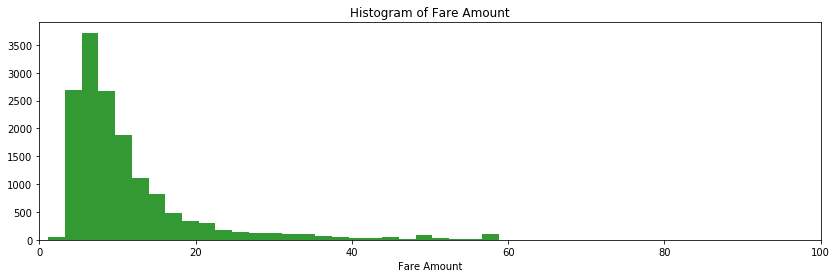

In [51]:
#let's visualize fare_amount
plt.figure(figsize = (14, 4))
n, bins, patches = plt.hist(train.fare_amount, 50, facecolor='green', alpha=0.8)
plt.xlabel('Fare Amount')
plt.title('Histogram of Fare Amount')
plt.xlim(0, 100)
plt.show();

In [60]:
#as we can see in the histogram most Fare drops between 5 to 15 dollars indicating short trips

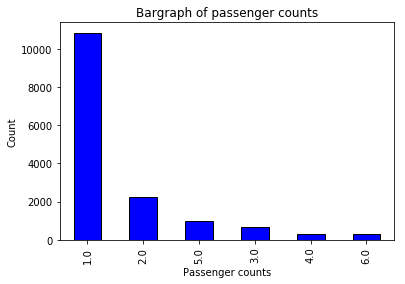

In [52]:
#now lets visualize passenger_count
train['passenger_count'].value_counts().plot.bar(color = 'blue', edgecolor = 'black');
plt.title('Bargraph of passenger counts'); plt.xlabel('Passenger counts'); plt.ylabel('Count');

In [62]:
#you can see in the above bargraph that most of the time single passengers have booked cab and family booking is least

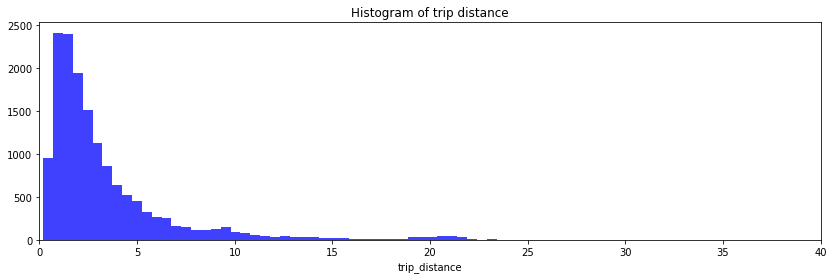

In [53]:
#lets visualize the trip_distance\
plt.figure(figsize = (14, 4))
n, bins, patches = plt.hist(train.trip_distance, 200, facecolor='blue', alpha=0.75)
plt.xlabel('trip_distance')
plt.xlim(0, 40)
plt.title('Histogram of trip distance')
plt.show();

In [64]:
#in the above histogram we can see that maximum no. of times people took short trips between somewhere 0.7 to 3 KM


In [39]:
train.shape

(15340, 13)

In [32]:
def modeling(data,target,drop_cols,split=0.25):
    new_data=data.drop(drop_cols,axis=1)
    X=new_data.drop([target],axis=1)
    y=new_data[target]
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=split,random_state=42)
    print("train shape",X_train.shape)
    print("test shape",X_test.shape)
    return X_train, X_test, y_train, y_test
    return new_data

In [33]:
X_train, X_test, y_train, y_test=modeling(train,'fare_amount',drop_cols=['pickup_datetime'],split=0.2)

train shape (12272, 11)
test shape (3068, 11)


In [57]:
train.dtypes

fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count             float64
day                         float64
year                        float64
month                       float64
hour                        float64
weekday                     float64
trip_distance               float64
dtype: object

In [58]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,year,month,hour,weekday,trip_distance
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1.0,15.0,2009.0,6.0,17.0,0.0,1.030764
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1.0,5.0,2010.0,1.0,16.0,1.0,8.450134
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2.0,18.0,2011.0,8.0,0.0,3.0,1.389525
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1.0,21.0,2012.0,4.0,4.0,5.0,2.799270
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1.0,9.0,2010.0,3.0,7.0,1.0,1.999157


In [59]:
test.dtypes

pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
day                           int64
year                          int64
month                         int64
hour                          int64
weekday                       int64
trip_distance               float64
dtype: object

## Model Development

#### Linear Regression

In [34]:
# Train the model using the training sets
model1 = sm.OLS(y_train, X_train).fit()

In [35]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fare_amount   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     7130.
Date:                Mon, 02 Sep 2019   Prob (F-statistic):               0.00
Time:                        13:04:41   Log-Likelihood:                -38071.
No. Observations:               12272   AIC:                         7.616e+04
Df Residuals:                   12261   BIC:                         7.625e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
pickup_longitude    -13.2237      1.227    -10.773      0.000     -15.630     -10.818
pickup_latitude     -43.4709      1.719    -25.287      0.000     -46.841     -40.101
dropoff_longitude     3.7004      1.223      3.025      0.002       1.303       6.098
dropoff_latitude     -6.2047      1.620     -3.830      0.000      -9.380      -3.029
passenger_count       0.0510      0.039      1.321      0.186      -0.025       0.127
day                  -0.0002      0.006     -0.044      0.965      -0.011       0.011
year                  0.6583      0.025     26.013      0.000       0.609       0.708
month                 0.1071      0.014      7.557      0.000       0.079       0.135
hour                  0.0059      0.008      0.780      0.436      -0.009       0.021
weekday              -0.0897      0.025     -3.610      0.000      -0.138      -0.041
trip_distance         1.8394      0.013    145.320      0.000       1.815       1.864
==============================================================================
Omnibus:                    15533.389   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         32449063.719
Skew:                          -6.008   Prob(JB):                         0.00
Kurtosis:                     254.625   Cond. No.                     8.69e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.69e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
y_pred1=model1.predict(X_test)

#### Lets use RMSE to test accuracy of the Model

In [37]:
lm_rmse=np.sqrt(mean_squared_error(y_pred1, y_test))
print("RMSE for Linear Regression is ",lm_rmse)

RMSE for Linear Regression is  5.483912516827407


##### Now lets try another linear regression by changing split

In [39]:
X_train1, X_test1, y_train1, y_test1=modeling(train,'fare_amount',drop_cols=['pickup_datetime'],split=0.3)

train shape (10738, 11)
test shape (4602, 11)


In [40]:
# Train the model using the training sets
model2 = sm.OLS(y_train1, X_train1).fit()

In [41]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fare_amount   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     6077.
Date:                Mon, 02 Sep 2019   Prob (F-statistic):               0.00
Time:                        13:05:02   Log-Likelihood:                -33384.
No. Observations:               10738   AIC:                         6.679e+04
Df Residuals:                   10727   BIC:                         6.687e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
pickup_longitude    -13.3092      1.315    -10.125      0.000     -15.886     -10.732
pickup_latitude     -49.1592      1.832    -26.833      0.000     -52.750     -45.568
dropoff_longitude     2.1519      1.315      1.636      0.102      -0.426       4.730
dropoff_latitude     -3.5173      1.739     -2.022      0.043      -6.927      -0.108
passenger_count       0.0438      0.041      1.063      0.288      -0.037       0.125
day                  -0.0020      0.006     -0.336      0.737      -0.014       0.010
year                  0.6591      0.027     24.188      0.000       0.606       0.713
month                 0.1033      0.015      6.765      0.000       0.073       0.133
hour                  0.0042      0.008      0.516      0.606      -0.012       0.020
weekday              -0.0970      0.027     -3.626      0.000      -0.149      -0.045
trip_distance         1.7927      0.014    132.620      0.000       1.766       1.819
==============================================================================
Omnibus:                    13667.474   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         23448967.651
Skew:                          -6.136   Prob(JB):                         0.00
Kurtosis:                     231.602   Cond. No.                     8.67e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.67e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [42]:
y_pred2=model2.predict(X_test1)

In [43]:
lm_rmse=np.sqrt(mean_squared_error(y_pred2, y_test1))
print("RMSE for Linear Regression is ",lm_rmse)

RMSE for Linear Regression is  5.382596109443943


#### DecisionTree

In [44]:
#Decision tree for regression
fit_DT = DecisionTreeRegressor(max_depth=6,random_state=42).fit(X_train, y_train)

In [45]:
predictions_DT = fit_DT.predict(X_test)

#### Lets use RMSE to test accuracy of the Model

In [46]:
dt_rmse=np.sqrt(mean_squared_error(predictions_DT,y_test))
print("RMSE = ",dt_rmse)

RMSE =  3.697995334587334


#### Random Forest

In [47]:
fit_RF = RandomForestRegressor(n_estimators = 50,random_state=42).fit(X_train,y_train)

In [48]:
prediction_RF=fit_RF.predict(X_test)

#### Lets use RMSE to test accuracy of the Model

In [49]:
rf_rmse=np.sqrt(mean_squared_error(prediction_RF,y_test))
print("RMSE = ",rf_rmse)

RMSE =  3.623520364101185


### As we got best Accuracy with RandomForest Model we will use this Model to predict Fare

In [75]:
test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,year,month,hour,weekday,trip_distance
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273,16.194170,2011.815816,6.857979,13.467420,2.852834,3.435371
std,0.042774,0.033541,0.039072,0.035435,1.278747,8.838482,1.803347,3.353272,6.868584,1.994451,3.972374
min,-74.252193,40.573143,-74.263242,40.568973,1.000000,1.000000,2009.000000,1.000000,0.000000,0.000000,0.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000,9.000000,2010.000000,4.000000,8.000000,1.000000,1.298277
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000,16.000000,2012.000000,7.000000,15.000000,3.000000,2.217412
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000,25.000000,2014.000000,10.000000,19.000000,5.000000,4.045302
max,-72.986532,41.709555,-72.990963,41.696683,6.000000,31.000000,2015.000000,12.000000,23.000000,6.000000,99.996040


In [76]:
test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,year,month,hour,weekday,trip_distance
0,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1,27,2015,1,13,1,2.323259
1,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1,27,2015,1,13,1,2.425353
2,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,1,8,2011,10,11,5,0.618628
3,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,1,1,2012,12,21,5,1.961033
4,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,1,1,2012,12,21,5,5.387301


In [77]:
test=test.drop(['pickup_datetime'], axis=1)

In [78]:
test.shape

(9914, 11)

In [79]:
predicted_fare=fit_RF.predict(test)

In [80]:
test['predicted_fare']=predicted_fare

In [81]:
test.head(10)

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,year,month,hour,weekday,trip_distance,predicted_fare
0,-73.973320,40.763805,-73.981430,40.743835,1,27,2015,1,13,1,2.323259,10.236817
1,-73.986862,40.719383,-73.998886,40.739201,1,27,2015,1,13,1,2.425353,10.468000
2,-73.982524,40.751260,-73.979654,40.746139,1,8,2011,10,11,5,0.618628,4.020000
3,-73.981160,40.767807,-73.990448,40.751635,1,1,2012,12,21,5,1.961033,9.924000
4,-73.966046,40.789775,-73.988565,40.744427,1,1,2012,12,21,5,5.387301,16.208000
5,-73.960983,40.765547,-73.979177,40.740053,1,1,2012,12,21,5,3.222549,9.132000
6,-73.949013,40.773204,-73.959622,40.770893,1,6,2011,10,12,3,0.929601,5.814000
7,-73.777282,40.646636,-73.985083,40.759368,1,6,2011,10,12,3,21.540102,49.577800
8,-74.014099,40.709638,-73.995106,40.741365,1,6,2011,10,12,3,3.873962,11.596000
9,-73.969582,40.765519,-73.980686,40.770725,1,18,2014,2,15,1,1.099794,7.250000


In [82]:
test.to_csv("test_predicted.csv",index=False)